In [2]:
# %load ../uoicorr_imports.py
%load_ext autoreload
%autoreload 2
import h5py

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from math import floor, ceil

# Script to add the entire project directory structure to the python path
import sys, os

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
	parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
	sys.path.append(p)

# And standard list of subdirectories
if '%s\\pyuoi' % p not in sys.path:
	sys.path.append('%s\\pyuoi' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

if '%s\\uoicorr' % p not in sys.path:
    sys.path.append('%s\\uoicorr' % p)

from postprocess import postprocess_file, postprocess_dir
from utils import FNR, FPR, selection_accuracy

In [15]:
dat = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\02082019')

(180, 28)


### First stick to R^2 estimation scores

In [17]:
dat_r2 = dat.loc[dat['est_score'] == 'r2']

In [18]:
uoil = dat_r2.loc[dat['exp_type'] == 'UoILasso']
uoien = dat_r2.loc[dat['exp_type'] == 'UoIElasticNet']
en = dat_r2.loc[dat['exp_type'] == 'EN']

In [19]:
uoil.shape

(60, 28)

### False negative rates

In [20]:
# Make separate plots for each sparsity, plot as a function of falloff distance

# Select the relevant data:
dat_uoil = []
dat_uoil.append(uoil.loc[(uoil['sparsity'] == 0.2)])
dat_uoil.append(uoil.loc[(uoil['sparsity'] == 0.4)])
dat_uoil.append(uoil.loc[(uoil['sparsity'] == 0.6)])
dat_uoil.append(uoil.loc[(uoil['sparsity'] == 0.8)])
dat_uoil.append(uoil.loc[(uoil['sparsity'] == 1)])

# Select the relevant data:
dat_uoien = []
dat_uoien.append(uoien.loc[(uoien['sparsity'] == 0.2)])
dat_uoien.append(uoien.loc[(uoien['sparsity'] == 0.4)])
dat_uoien.append(uoien.loc[(uoien['sparsity'] == 0.6)])
dat_uoien.append(uoien.loc[(uoien['sparsity'] == 0.8)])
dat_uoien.append(uoien.loc[(uoien['sparsity'] == 1)])

# Select the relevant data:
dat_en = []
dat_en.append(en.loc[(en['sparsity'] == 0.2)])
dat_en.append(en.loc[(en['sparsity'] == 0.4)])
dat_en.append(en.loc[(en['sparsity'] == 0.6)])
dat_en.append(en.loc[(en['sparsity'] == 0.8)])
dat_en.append(en.loc[(en['sparsity'] == 1)])

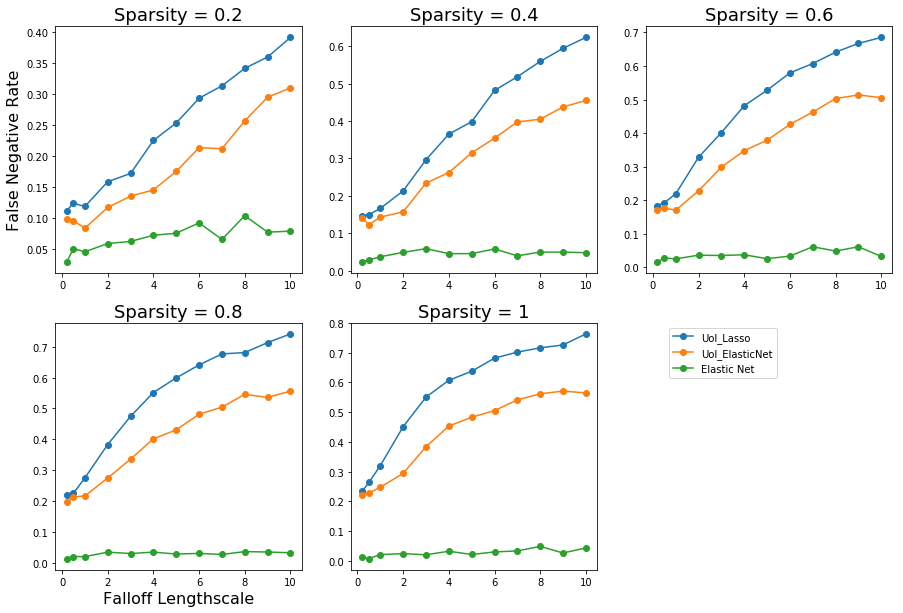

In [8]:
L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(len(dat_uoil)):
    d1 = dat_uoil[i]
    d2 = dat_uoien[i]
    d3 = dat_en[i]

    fn_avg_uoil = [np.mean(FNR(d1.iloc[j].betas, d1.iloc[j].beta_hats)) for j in range(len(L))]
    fn_avg_uoien = [np.mean(FNR(d2.iloc[j].betas, d2.iloc[j].beta_hats)) for j in range(len(L))]
    fn_avg_en = [np.mean(FNR(d3.iloc[j].betas, d3.iloc[j].beta_hats)) for j in range(len(L))]
    
    a = ax[np.unravel_index(i, (2, 3))]
    a.plot(L, fn_avg_uoil, '-o')
    a.plot(L, fn_avg_uoien, '-o')
    a.plot(L, fn_avg_en, '-o')
    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('False Negative Rate', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso', 'UoI_ElasticNet', 'Elastic Net'], loc = 'upper right', bbox_to_anchor=(1.75, 1))

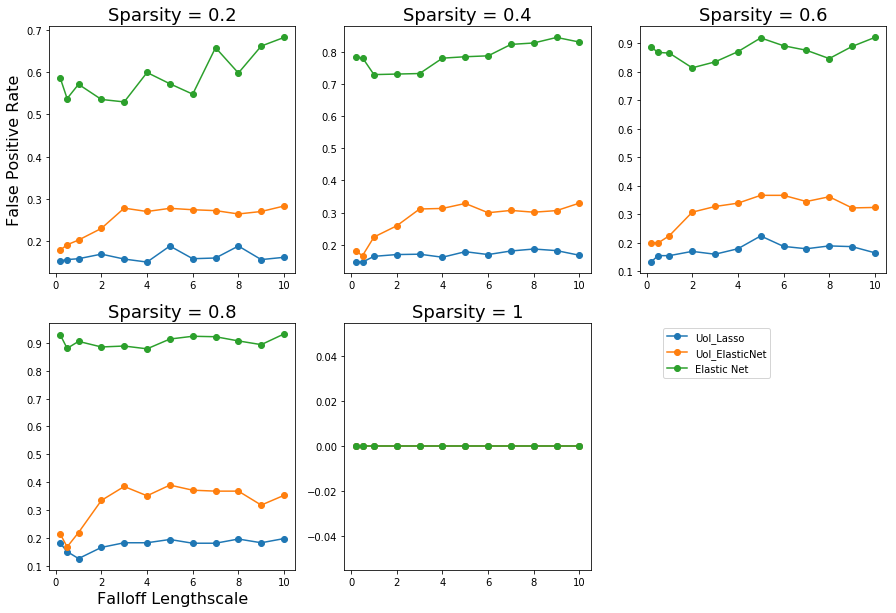

In [10]:
L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(len(dat_uoil)):
    d1 = dat_uoil[i]
    d2 = dat_uoien[i]
    d3 = dat_en[i]

    nonzero_beta = int(sparsity[i] * 60)
    
    # Organize by block_size and L
    fn_avg_uoil = [np.mean(FPR(d1.iloc[j].betas, d1.iloc[j].beta_hats)) for j in range(len(L))]
    fn_avg_uoien = [np.mean(FPR(d2.iloc[j].betas, d2.iloc[j].beta_hats)) for j in range(len(L))]
    fn_avg_en = [np.mean(FPR(d3.iloc[j].betas, d3.iloc[j].beta_hats)) for j in range(len(L))]
        
    a = ax[np.unravel_index(i, (2, 3))]
    a.plot(L, fn_avg_uoil, '-o')
    a.plot(L, fn_avg_uoien, '-o')
    a.plot(L, fn_avg_en, '-o')
    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('False Positive Rate', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso', 'UoI_ElasticNet', 'Elastic Net'], loc = 'upper right', bbox_to_anchor=(1.75, 1))

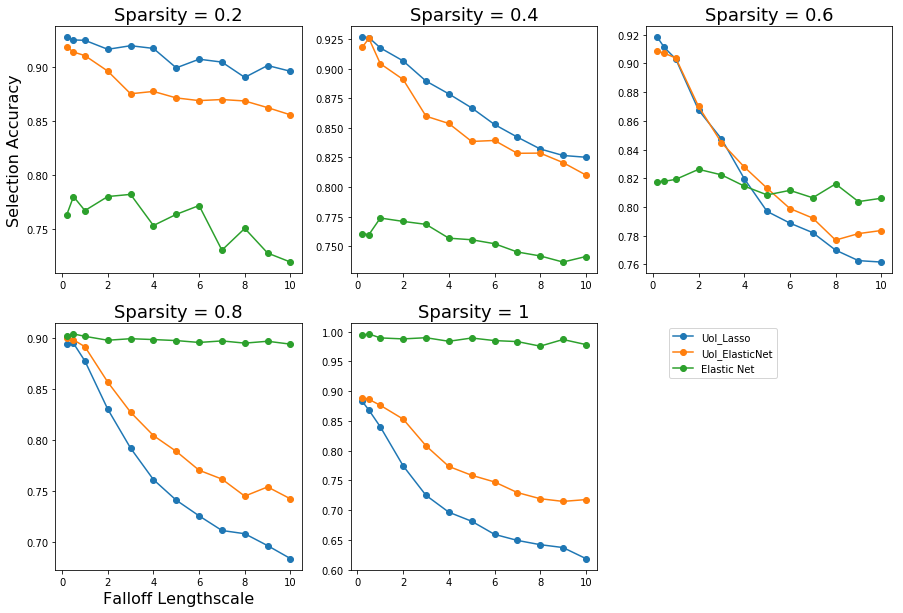

In [12]:
L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(len(dat_uoil)):
    d1 = dat_uoil[i]
    d2 = dat_uoien[i]
    d3 = dat_en[i]

    # Organize by block_size and correlation
    sa_avg_uoil = [np.mean(selection_accuracy(d1.iloc[j].betas, d1.iloc[j].beta_hats)) for j in range(len(L))]
    sa_avg_uoien = [np.mean(selection_accuracy(d2.iloc[j].betas, d2.iloc[j].beta_hats)) for j in range(len(L))]
    sa_avg_en = [np.mean(selection_accuracy(d3.iloc[j].betas, d3.iloc[j].beta_hats)) for j in range(len(L))]
    
    a = ax[np.unravel_index(i, (2, 3))]
    a.plot(L, sa_avg_uoil, '-o')
    a.plot(L, sa_avg_uoien, '-o')
    a.plot(L, sa_avg_en, '-o')
    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('Selection Accuracy', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso', 'UoI_ElasticNet', 'Elastic Net'], loc = 'upper right', bbox_to_anchor=(1.75, 1))

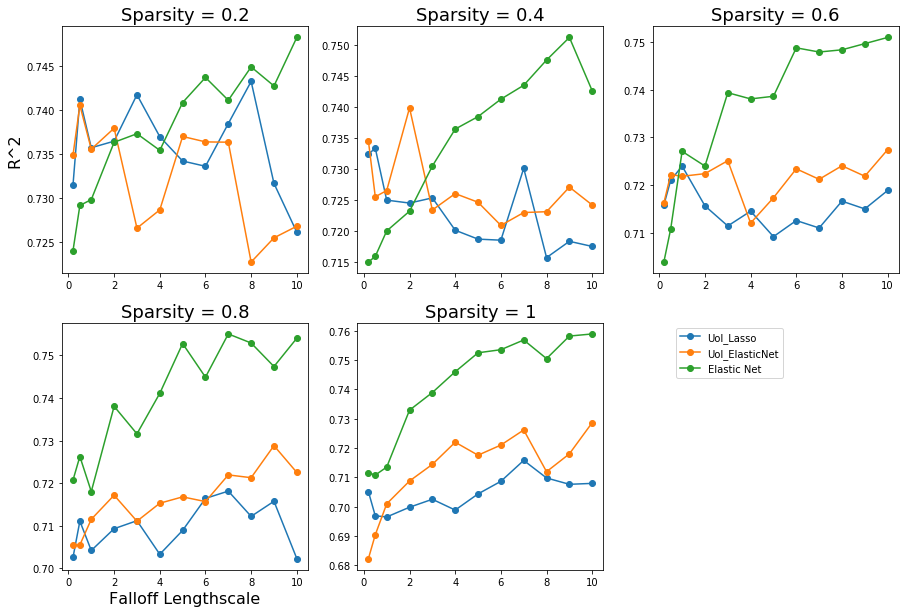

In [13]:
L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(len(dat_uoil)):
    d1 = dat_uoil[i]
    d2 = dat_uoien[i]
    d3 = dat_en[i]

    nonzero_beta = int(sparsity[i] * 60)
    
    # Organize by block_size and L
    r2_avg_uoil = [np.mean(d1.iloc[j].r2) for j in range(len(L))]
    r2_avg_uoien = [np.mean(d2.iloc[j].r2) for j in range(len(L))]
    r2_avg_en = [np.mean(d3.iloc[j].r2) for j in range(len(L))]

    r2t_avg_uoil = [np.mean(d1.iloc[j].r2_true) for j in range(len(L))]
    r2t_avg_uoien = [np.mean(d2.iloc[j].r2_true) for j in range(len(L))]
    r2t_avg_en = [np.mean(d3.iloc[j].r2_true) for j in range(len(L))]

    a = ax[np.unravel_index(i, (2, 3))]
    a.plot(L, r2_avg_uoil, '-o')
    a.plot(L, r2_avg_uoien, '-o')
    a.plot(L, r2_avg_en, '-o')

    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('R^2', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso', 'UoI_ElasticNet', 'Elastic Net'], loc = 'upper right', bbox_to_anchor=(1.75, 1))

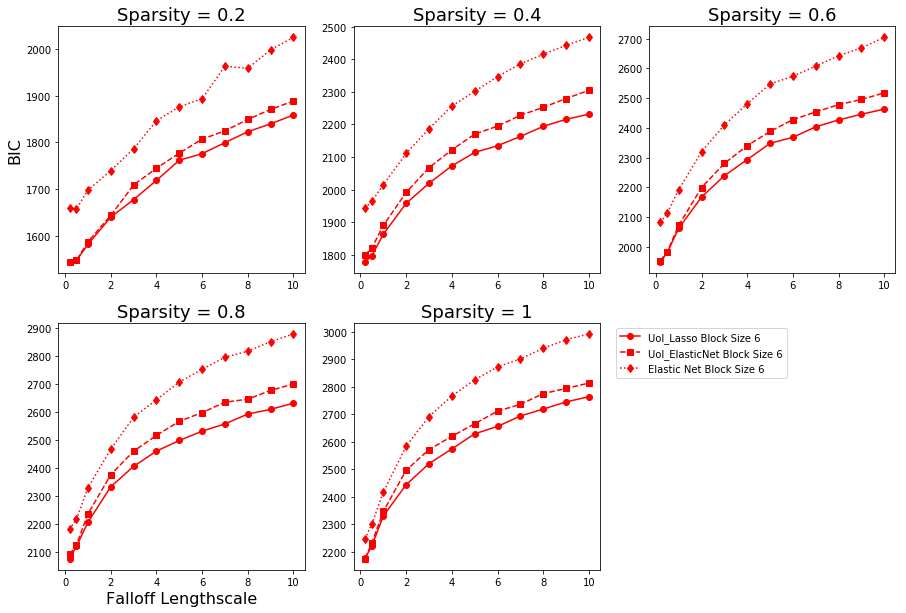

In [23]:
# Plot BIC, AIC

L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
block_size = [6, 12, 20]
# Match block size colors
colors = ['red', 'blue', 'green', 'cyan']
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for i in range(len(dat_uoil)):
    a = ax[np.unravel_index(i, (2, 3))]
    d1 = dat_uoil[i]
    d2 = dat_uoien[i]
    d3 = dat_en[i]

    nonzero_beta = int(sparsity[i] * 60)

    # Organize by block_size and L
    BIC_avg_uoil = [np.mean(d1.iloc[j].BIC) for j in range(len(L))]
    BIC_avg_uoien = [np.mean(d2.iloc[j].BIC) for j in range(len(L))]
    BIC_avg_en = [np.mean(d3.iloc[j].BIC) for j in range(len(L))]

    a.plot(L, BIC_avg_uoil, '-o', color = colors[j])
    a.plot(L, BIC_avg_uoien, '--s', color = colors[j])
    a.plot(L, BIC_avg_en, ':d', color = colors[j])
        
        
#    a.plot(L, r2t_avg, '--', color = 'green')
    
    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('BIC', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso Block Size 6', 'UoI_ElasticNet Block Size 6', 'Elastic Net Block Size 6',
                                        'UoI_Lasso Block Size 30', 'UoI_ElasticNet Block Size 30', 'Elastic Net Block Size 30',
                                        'True Model R^2'], bbox_to_anchor=(1.78, 1))
#plt.savefig('C:\\Users\\akumar\\nse\\uoicorr\\figs\\revisions/block_r2.png')

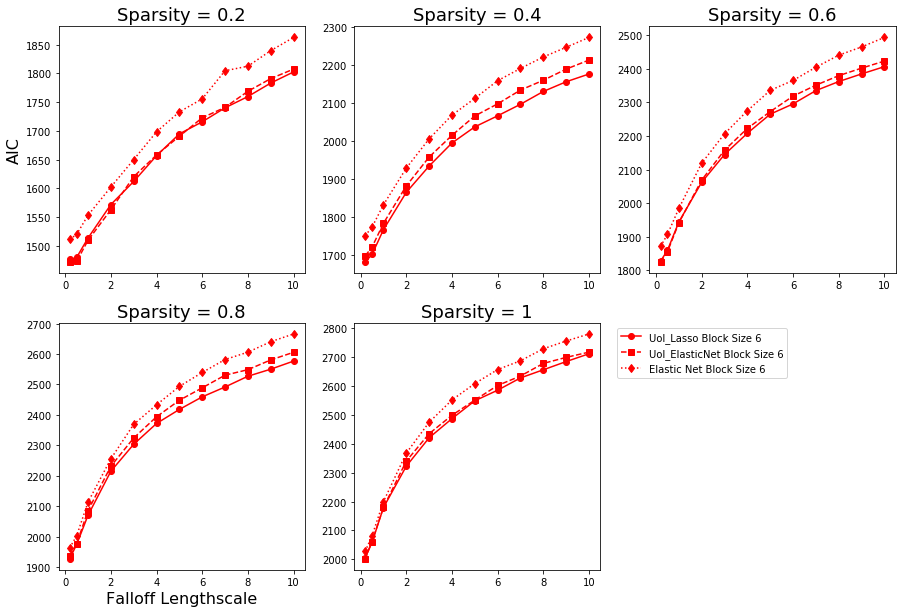

In [26]:
# Plot BIC, AIC

L = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
block_size = [6, 12, 20]
# Match block size colors
colors = ['red', 'blue', 'green', 'cyan']
sparsity = [0.2, 0.4, 0.6, 0.8, 1]
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

for i in range(len(dat_uoil)):
    a = ax[np.unravel_index(i, (2, 3))]
    d1 = dat_uoil[i]
    d2 = dat_uoien[i] 
    d3 = dat_en[i]

    nonzero_beta = int(sparsity[i] * 60)

    # Organize by block_size and L
    AIC_avg_uoil = [np.mean(d1.iloc[j].AIC) for j in range(len(L))]
    AIC_avg_uoien = [np.mean(d2.iloc[j].AIC) for j in range(len(L))]
    AIC_avg_en = [np.mean(d3.iloc[j].AIC) for j in range(len(L))]

    a.plot(L, AIC_avg_uoil, '-o', color = colors[j])
    a.plot(L, AIC_avg_uoien, '--s', color = colors[j])
    a.plot(L, AIC_avg_en, ':d', color = colors[j])
        
        
#    a.plot(L, r2t_avg, '--', color = 'green')
    
    
fig.delaxes(ax[1, 2])
ax[np.unravel_index(0, (2, 3))].set_title('Sparsity = 0.2', fontsize=18)
ax[np.unravel_index(0, (2, 3))].set_ylabel('AIC', fontsize=16)
ax[np.unravel_index(1, (2, 3))].set_title('Sparsity = 0.4', fontsize=18)
ax[np.unravel_index(2, (2, 3))].set_title('Sparsity = 0.6', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_title('Sparsity = 0.8', fontsize=18)
ax[np.unravel_index(3, (2, 3))].set_xlabel('Falloff Lengthscale', fontsize=16)
ax[np.unravel_index(4, (2, 3))].set_title('Sparsity = 1', fontsize=18)
ax[np.unravel_index(4, (2, 3))].legend(['UoI_Lasso Block Size 6', 'UoI_ElasticNet Block Size 6', 'Elastic Net Block Size 6',
                                        'UoI_Lasso Block Size 30', 'UoI_ElasticNet Block Size 30', 'Elastic Net Block Size 30',
                                        'True Model R^2'], bbox_to_anchor=(1.78, 1))
#plt.savefig('C:\\Users\\akumar\\nse\\uoicorr\\figs\\revisions/block_r2.png')